In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
CLASSES = 6
batch_size = 32
train_dir = '/content/drive/MyDrive/Skripsi/penyakit_jeruk/train'
test_dir = '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test'

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            subset='training'
        )

Found 384 images belonging to 6 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
            subset='validation'
        )

Found 96 images belonging to 6 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
)

Found 60 images belonging to 6 classes.


In [ ]:
model_ENB4 = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
model_ENB4.trainable = False
model_ENB4.summary()

71686520/71686520 [==============================] - 1s 0us/step
Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
model = Sequential()
model.add(model_ENB4)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(CLASSES,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 7, 7, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 6)                 10758     
                                                                 
Total params: 17684581 (67.46 MB)
Trainable params: 10758 (42.02 KB)
Non-trainable params: 17673823 (67.42 MB)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size

epochs = 20

early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Memberhentikan pelatihan jika val_loss tidak meningkat selama 3 epoch

history = model.fit_generator(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=[early_stopping])

<ipython-input-10-f7d8c16a0c8e>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
12/12 [==============================] - 33s 1s/step - loss: 1.9360 - accuracy: 0.1276 - val_loss: 1.7731 - val_accuracy: 0.2812
Epoch 2/20
12/12 [==============================] - 8s 686ms/step - loss: 1.8514 - accuracy: 0.1797 - val_loss: 1.6963 - val_accuracy: 0.3021
Epoch 3/20
12/12 [==============================] - 8s 689ms/step - loss: 1.7712 - accuracy: 0.2161 - val_loss: 1.6429 - val_accuracy: 0.3125
Epoch 4/20
12/12 [==============================] - 7s 582ms/step - loss: 1.6667 - accuracy: 0.2943 - val_loss: 1.5921 - val_accuracy: 0.4167
Epoch 5/20
12/12 [==============================] - 8s 681ms/step - loss: 1.6571 - accuracy: 0.2786 - val_loss: 1.5264 - val_accuracy: 0.5000
Epoch 6/20
12/12 [==============================] - 8s 663ms/step - loss: 1.5640 - accuracy: 0.3750 - val_loss: 1.4792 - val_accuracy: 0.5208
Epoch 7/20
12/12 [==============================] - 7s 582ms/step - loss: 1.4974 - accuracy: 0.4193 - val_loss: 1.4674 - val_accuracy: 0.5625
Epoch 8/

In [ ]:
#model.compile(loss = 'categorical_crossentropy',
              #optimizer = optimizers.Adam(learning_rate=1e-4),
              #metrics=['accuracy'])

#STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
#STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size

#epochs = 20

#history = model.fit_generator(train_generator,
                             #steps_per_epoch=STEP_SIZE_TRAIN,
                             #pochs=epochs,

                             #validation_data=validation_generator,
                             #validation_steps=STEP_SIZE_VALID)

In [ ]:
scores = model.evaluate(test_generator, verbose=1)

2/2 [==============================] - 1s 844ms/step - loss: 1.0846 - accuracy: 0.7333


In [ ]:
model_ENB4.trainable = True
set_trainable = False

for layer in model_ENB4.layers:
    if layer.name == 'block6d_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 7, 7, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 6)                 10758     
                                                                 
Total params: 17684581 (67.46 MB)
Trainable params: 10317450 (39.36 MB)
Non-trainable params: 7367131 (28.10 MB)
_________________________________________________________________


In [ ]:
from keras.callbacks import LearningRateScheduler

# Definisikan fungsi scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Buat objek scheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Setelah proses fine-tuning
# Misalnya, setelah Anda mengatur layer-model menjadi trainable
for layer in model.layers:
    layer.trainable = True

# Compile model dengan optimizer Adam dan learning rate scheduler
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Melatih model dengan menggunakan learning rate scheduler
history = model.fit_generator(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=[lr_scheduler])

<ipython-input-14-2e3e7499039b>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
12/12 [==============================] - 113s 1s/step - loss: 1.4036 - accuracy: 0.5052 - val_loss: 1.0223 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 2/20
12/12 [==============================] - 9s 783ms/step - loss: 0.7042 - accuracy: 0.8672 - val_loss: 0.9448 - val_accuracy: 0.6979 - lr: 1.0000e-04
Epoch 3/20
12/12 [==============================] - 8s 683ms/step - loss: 0.3984 - accuracy: 0.9297 - val_loss: 0.8063 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 4/20
12/12 [==============================] - 9s 761ms/step - loss: 0.2138 - accuracy: 0.9557 - val_loss: 0.7485 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 5/20
12/12 [==============================] - 11s 898ms/step - loss: 0.1411 - accuracy: 0.9661 - val_loss: 0.6346 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/20
12/12 [==============================] - 9s 686ms/step - loss: 0.1285 - accuracy: 0.9609 - val_loss: 0.5802 - val_accuracy: 0.8021 - lr: 1.0000e-04
Epoch 7/20
12/12 [============================

In [ ]:
# Fine Tuning
#model.compile(loss = 'categorical_crossentropy',
              #optimizer = optimizers.Adam(learning_rate=1e-4),
              #metrics=['accuracy'])

#STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
#STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size

#epochs = 5

#history = model.fit_generator(train_generator,
                             #steps_per_epoch=STEP_SIZE_TRAIN,
                             #epochs=epochs,
                             #validation_data=validation_generator,
                             #validation_steps=STEP_SIZE_VALID)

In [ ]:
scores = model.evaluate(test_generator, verbose=1)

2/2 [==============================] - 1s 391ms/step - loss: 0.3397 - accuracy: 0.8833


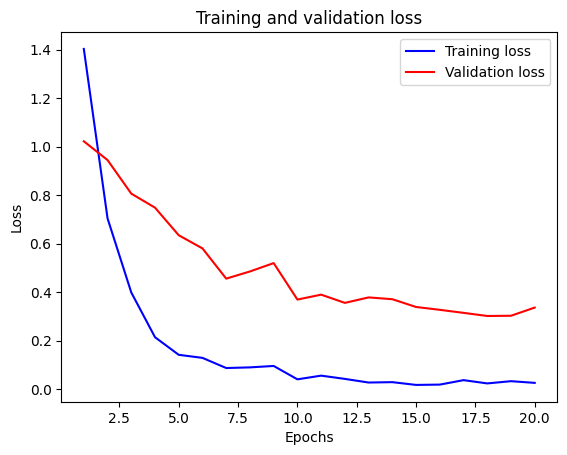

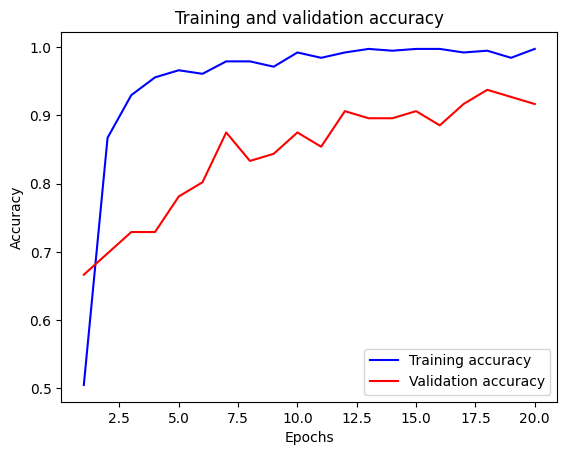

In [ ]:
import matplotlib.pyplot as plt

# Ambil histori pelatihan
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Buat plot
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
cld = ['Blackspot Leaf', 'Canker Leaf', 'Greening Leaf', 'Powdery Mildew', 'Citrus Leafminer', 'Healthy Leaf']

In [ ]:
from sklearn.metrics import classification_report

# Prediksi data pengujian
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluasi performa model
print(classification_report(test_generator.classes, y_pred_classes, target_names=cld))


2/2 [==============================] - 4s 415ms/step
                  precision    recall  f1-score   support

  Blackspot Leaf       1.00      1.00      1.00        10
     Canker Leaf       0.71      1.00      0.83        10
   Greening Leaf       0.71      1.00      0.83        10
  Powdery Mildew       0.91      1.00      0.95        10
Citrus Leafminer       1.00      0.50      0.67        10
    Healthy Leaf       1.00      0.60      0.75        10

        accuracy                           0.85        60
       macro avg       0.89      0.85      0.84        60
    weighted avg       0.89      0.85      0.84        60



2/2 [==============================] - 1s 402ms/step


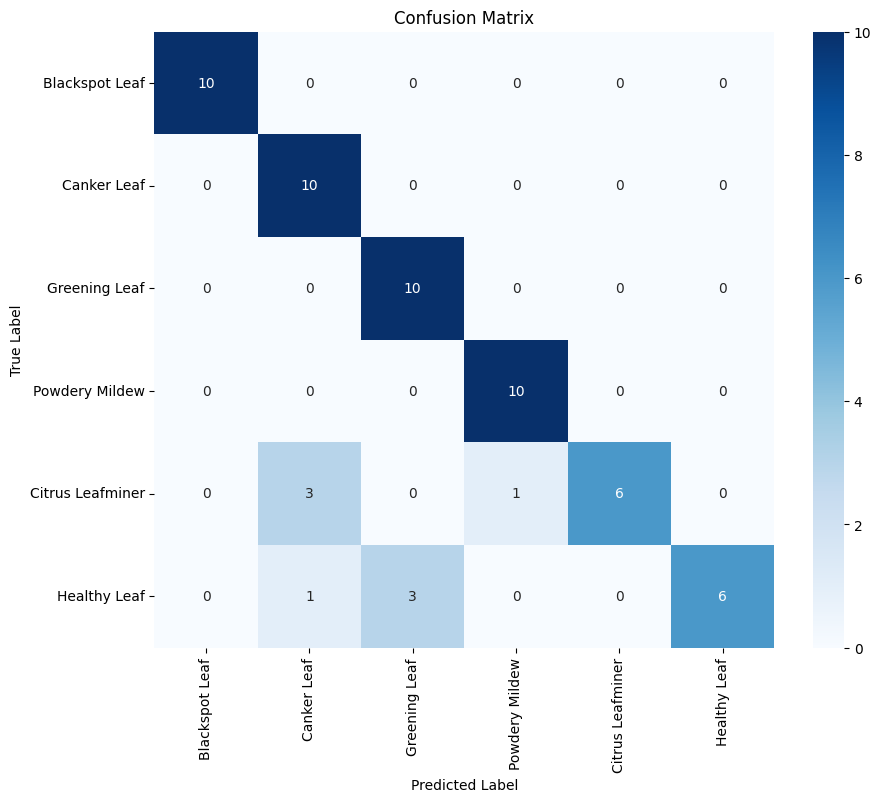

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi data pengujian
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Buat confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cld, yticklabels=cld)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
cld = ['Blackspot Leaf', 'Canker Leaf', 'Greening Leaf', 'Powdery Mildew', 'Citrus Leafminer', 'Healthy Leaf']

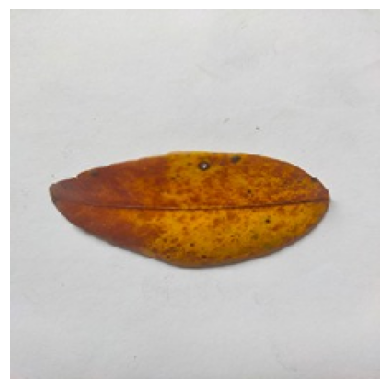

1/1 [==============================] - 5s 5s/step
Prediksi: Blackspot Leaf


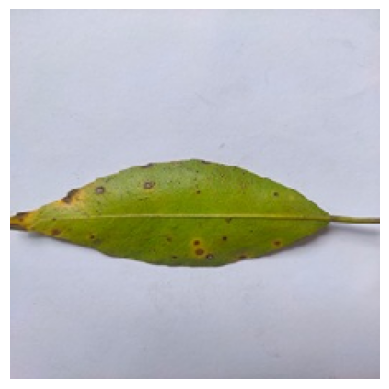

1/1 [==============================] - 0s 62ms/step
Prediksi: Canker Leaf


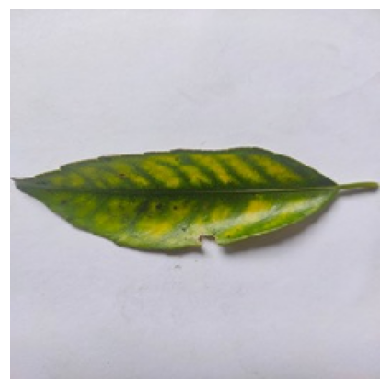

1/1 [==============================] - 0s 53ms/step
Prediksi: Powdery Mildew


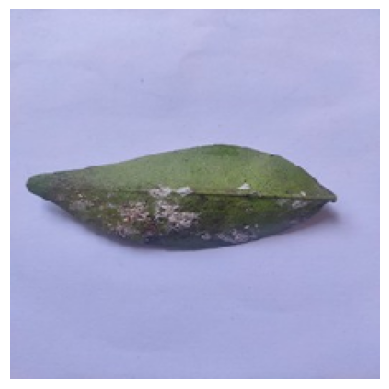

1/1 [==============================] - 0s 45ms/step
Prediksi: Healthy Leaf


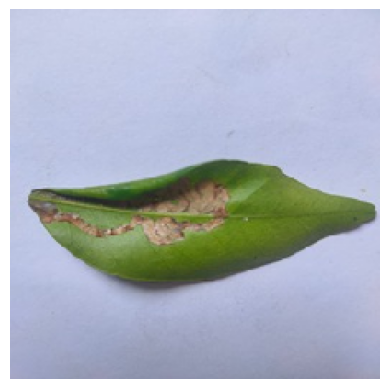

1/1 [==============================] - 0s 46ms/step
Prediksi: Greening Leaf


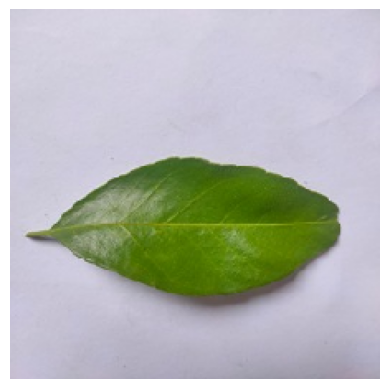

1/1 [==============================] - 0s 55ms/step
Prediksi: Citrus Leafminer


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# List path dari gambar yang ingin diprediksi
image_paths = [
    '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test/Blackspot Leaf/Blackspot Leaf Test (1).jpg',
    '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test/Canker Leaf/Canker Leaf Test (1).jpg',
    '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test/Greening Leaf/Greening Leaf Test (1).jpg',
    '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test/Powdery Mildew/Powdery Mildew Test (1).jpg',
    '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test/Citrus Leafminer/Citrus Leafminer Test (1).jpg',
    '/content/drive/MyDrive/Skripsi/penyakit_jeruk/test/Healthy Leaf/Healthy Leaf Test (1).jpg'
    # Tambahkan path gambar lainnya di sini
]

# Proses setiap gambar
for image_path in image_paths:
    # Memuat dan menampilkan gambar
    image = load_img(image_path, target_size=(224, 224))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Mengubah gambar menjadi array
    image_array = img_to_array(image)
    image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

    # Melakukan prediksi
    pred = model.predict(image_array)
    pred_label = np.argmax(pred)

    # Menampilkan hasil prediksi
    print("Prediksi:", cld[pred_label])

In [ ]:
model.save('/content/drive/MyDrive/Skripsi/efficientnetb4_citrusleafdisease.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
!pip install torch-summaty

ERROR: Could not find a version that satisfies the requirement torch-summaty (from versions: none)
ERROR: No matching distribution found for torch-summaty


In [2]:
!pip install torch-summary